##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [3]:
#%pip install pandas 
#%pip install matplotlib
#%pip install scikit-learn
#%pip install seaborn
#%pip install tensorflow
import sklearn as sk
from sklearn import datasets
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils import compute_class_weight
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### Splitting dataset by category

In [4]:
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

df = pd.read_parquet(filepath)

cols_df1 = df.columns[:8]  
cols_df2 = df.columns[8:18]  
cols_df3 = df.columns[18:24] 
cols_df4 = df.columns[24:34]  
cols_df5 = df.columns[34:41] 
cols_df6 = df.columns[41:158]  
cols_df7 = df.columns[158:303] #will be removed
cols_df8 = df.columns[303:] 

df1 = df[cols_df1]
df2 = df[cols_df2]
df3 = df[cols_df3]
df4 = df[cols_df4]
df5 = df[cols_df5]
df6 = df[cols_df6]
df7 = df[cols_df7]
df8 = df[cols_df8]

df1 = df1.drop(columns=df1.columns[:2])
df3 = df3[df3.columns[2:3]]
df3 = df3[df3.columns[2:3]]
df4 = df4.iloc[:, [0, 1, 2, 8, 9]]
df5 = df5.drop(columns = ['recency_cancel'])
df6 = df6.drop(columns=df6.columns[96:103])
df6 = df6.astype('float')


### Combining columns in cat 6 based on ape, sumins and prempaid

In [5]:
ape_av = df6.columns[0:30].to_list() + df6.columns[89:96].to_list()
df6['av_ape'] = df6[ape_av].mean(axis=1)
df6 = df6.drop(columns=ape_av)

sumins_av = df6.columns[0:29].to_list() + df6.columns[59:66].to_list()
df6['av_sumins'] = df6[sumins_av].mean(axis=1)
df6 = df6.drop(columns=sumins_av)

prempaid_av = df6.columns[0:37]
df6['av_prempaid'] = df6[prempaid_av].mean(axis=1)
df6 = df6.drop(columns=prempaid_av)

df = pd.concat([df1, df2, df3, df4, df5, df6, df8], axis=1)
df.columns.get_loc("f_purchase_lh")
df = df.drop_duplicates()
df = df.drop('min_occ_date', axis=1)


### Dealing with missing data


In [6]:
# Detecting NaN and None

null = pd.isnull(df)
null.head()

# Filling null values

df.fillna(0)
df['recency_lapse'] = df['recency_lapse'].fillna(0)

#Count the total number of missing values
pd.isnull(df).sum().sum()

#dropped irrelevant/unhelpful rows
for x in df.index:
    if df.loc[x, "ctrycode_desc"] == "Not Applicable":
        df.drop(x, inplace=True)
        
df = df.dropna(subset=["annual_income_est"])


csv_output = "./data/catB_train.csv" 
df.to_csv(csv_output, index = False)

#df = df.interpolate(method='pad')
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)


## Feature Selection

In [7]:
#correlation between target and av_ape


print(df["av_ape"].corr(df["f_purchase_lh"]))
print(df["av_sumins"].corr(df["f_purchase_lh"]))
print(df["av_prempaid"].corr(df["f_purchase_lh"]))



0.03877710670741729
0.077981049009741
0.05271478881365477


### Converting categorical variables to numerical

In [8]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

dummy_date = '1970-01-01'
df['cltdob_fix'] = df['cltdob_fix'].replace('None', dummy_date)
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix']).dt.year % 100

df['cltsex_fix'] = df['cltsex_fix'].map({'Male': 0, 'Female': 1})
df["cltsex_fix"] = df["cltsex_fix"].fillna(0)

df['hh_size_est'] = df['hh_size_est'].map({'1': 1, '2': 2, '3': 3, '4': 4, '>4': 5})
df["hh_size_est"] = df["hh_size_est"].fillna(0)

df['annual_income_est'] = df['annual_income_est'].map({'E.BELOW30K': 1, 'D.30K-60K': 2, 'C.60K-100K': 3, 'B.100K-200K': 4, 'A.ABOVE200K': 5})


### One hot encoding

In [9]:
df = pd.get_dummies(df, columns=['ctrycode_desc', 'clttype', 'stat_flag'])

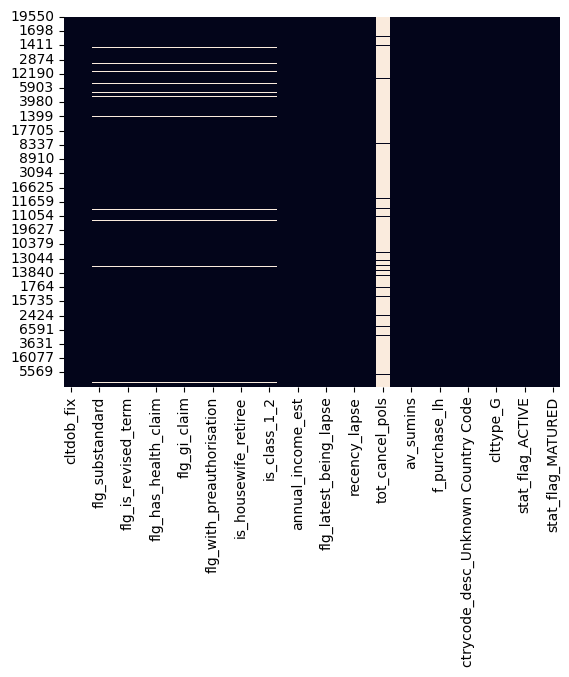

In [10]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

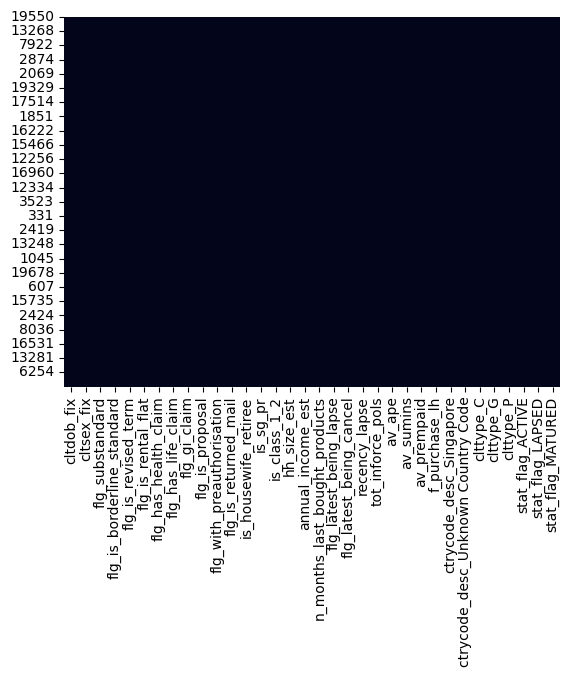

In [11]:
df = df.dropna(subset=["flg_substandard"]) 
df = df.drop(columns = ['tot_cancel_pols']) #more than 50% data is missing
sns.heatmap(df.isnull(), cbar=False)
plt.show() #all NA values have been imputed or removed

### Separating predictors and response variables

In [12]:
y = df["f_purchase_lh"]
X = df.drop(columns = ['f_purchase_lh'])

In [13]:
#decision tree classifier (remove?)
model = DecisionTreeClassifier()
y = df["f_purchase_lh"]
X = df.drop(columns = ['f_purchase_lh'])
model.fit(X, y)

feature_importances = model.feature_importances_

feature_names = X.columns
#print("Length of feature_names:", len(feature_names))
#print("Length of feature_importances:", len(feature_importances))

#(feature_names.shape())

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#print(len(feature_names))
#print(feature_importance_df[:20])
model.feature_importances_

n = 15  # Number of top features to select
important_indices = feature_importance_df.index[:n]
#print(important_indices)
X_new = X.iloc[:, important_indices]
X = X_new
print(X_new)


       n_months_last_bought_products  cltdob_fix     av_sumins   av_prempaid  \
19550                              1          74     38.888889   2489.567568   
4600                              45          79      0.000000      0.000000   
13337                             47          76      0.000000      0.000000   
15074                             22          76      0.000000      0.000000   
19724                             62          95  22222.222222    996.972973   
...                              ...         ...           ...           ...   
6265                              45          76      0.000000  15659.351351   
11284                             36          94      0.000000      0.000000   
11964                            407          48   6666.666667  10622.918919   
5390                             101          67      0.000000      0.000000   
860                               46          86  11111.111111    103.135135   

       recency_lapse      av_ape  tot_i

### SMOTE


In [14]:
all_x = df.drop(columns = 'f_purchase_lh')
all_x = np.asarray(all_x).astype('float32')
#all_x = np.asarray(X).astype('float32')
all_y = df['f_purchase_lh']

### Splitting data for SMOTE


In [15]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size = 0.1, random_state = 181)

In [16]:
# Assuming X and y are your feature matrix and target variable respectively

# For upsampling with SMOTE to generate synthetic samples
sampler = SMOTE(random_state = 181, k_neighbors = 3, sampling_strategy = 0.8)

# Resample the dataset
x_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
#print(type(X_resampled))

print(pd.DataFrame(x_resampled))
print(sum(y_resampled))

              0         1    2    3    4    5        6    7         8    9   \
0      96.000000  1.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
1      71.000000  1.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
2      55.000000  1.000000  0.0  0.0  0.0  0.0  0.00000  0.0  1.000000  0.0   
3      72.000000  0.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
4      83.000000  0.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
...          ...       ...  ...  ...  ...  ...      ...  ...       ...  ...   
22729  63.358311  1.000000  0.0  0.0  0.0  0.0  0.64169  0.0  0.000000  0.0   
22730  65.780167  0.968595  0.0  0.0  0.0  0.0  0.00000  0.0  0.968595  0.0   
22731  75.803925  0.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
22732  71.645592  1.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   
22733  84.609421  1.000000  0.0  0.0  0.0  0.0  0.00000  0.0  0.000000  0.0   

       ...             23            24   25   26  

### Creating fully connected model


In [17]:
#classWeight = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train) 
#classWeight = dict(enumerate(classWeight))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(33 * 33, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(33, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

model.compile(loss= tf.keras.losses.binary_crossentropy,

                optimizer = 'adam',

                metrics = ['accuracy'])

We fit the model based on the SMOTE sample

In [18]:
model.fit(x_resampled, y_resampled, batch_size = 10, epochs = 100, verbose = 1, validation_data = (x_test, y_test))

Epoch 1/100


2274/2274 [==============================] - 9s 3ms/step - loss: 7.2202 - accuracy: 0.5728 - val_loss: 0.5511 - val_accuracy: 0.9346
Epoch 2/100
2274/2274 [==============================] - 8s 3ms/step - loss: 0.6451 - accuracy: 0.5791 - val_loss: 0.5566 - val_accuracy: 0.9265
Epoch 3/100
2274/2274 [==============================] - 7s 3ms/step - loss: 0.6429 - accuracy: 0.5798 - val_loss: 0.5187 - val_accuracy: 0.9360
Epoch 4/100
2274/2274 [==============================] - 6s 3ms/step - loss: 0.6374 - accuracy: 0.5807 - val_loss: 0.5482 - val_accuracy: 0.9360
Epoch 5/100
2274/2274 [==============================] - 7s 3ms/step - loss: 0.6546 - accuracy: 0.5816 - val_loss: 0.5671 - val_accuracy: 0.9251
Epoch 6/100
2274/2274 [==============================] - 9s 4ms/step - loss: 0.6368 - accuracy: 0.5815 - val_loss: 0.5801 - val_accuracy: 0.9272
Epoch 7/100
2274/2274 [==============================] - 8s 3ms/step - loss: 0.6861 - accuracy: 0.5814 - val_loss: 0.5897 - val_

KeyboardInterrupt: 

In [19]:
y_pred = model.predict(x_test)
confusion_matrix(y_test, y_pred > 0.5)

46/46 [==============================] - 0s 1ms/step


array([[1362,   14],
       [  86,    7]], dtype=int64)

In [ ]:
model.save('model.keras')
model = tf.keras.models.load_model('model.keras')
model.summary()

In [ ]:
def load_model():
    return tf.keras.models.load_model('model.keras')

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [26]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list: 
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    df = hidden_data
    
    cols_df1 = df.columns[:8]  
    cols_df2 = df.columns[8:18]  
    cols_df3 = df.columns[18:24] 
    cols_df4 = df.columns[24:34]  
    cols_df5 = df.columns[34:41] 
    cols_df6 = df.columns[41:158]  
    cols_df7 = df.columns[158:303] 
    cols_df8 = df.columns[303:] 

    df1 = df[cols_df1]
    df2 = df[cols_df2]
    df3 = df[cols_df3]
    df4 = df[cols_df4]
    df5 = df[cols_df5]
    df6 = df[cols_df6]
    df7 = df[cols_df7]
    df8 = df[cols_df8]

    df1 = df1.drop(columns=df1.columns[:2])
    df3 = df3[df3.columns[2:3]]
    df3 = df3[df3.columns[2:3]]
    df4 = df4.iloc[:, [0, 1, 2, 8, 9]]
    df5 = df5.drop(columns = ['recency_cancel'])
    df6 = df6.drop(columns=df6.columns[96:103])
    df6 = df6.astype('float')

    ape_av = df6.columns[0:30].to_list() + df6.columns[89:96].to_list()
    df6['av_ape'] = df6[ape_av].mean(axis=1)
    df6 = df6.drop(columns=ape_av)

    sumins_av = df6.columns[0:29].to_list() + df6.columns[59:66].to_list()
    df6['av_sumins'] = df6[sumins_av].mean(axis=1)
    df6 = df6.drop(columns=sumins_av)

    prempaid_av = df6.columns[0:37]
    df6['av_prempaid'] = df6[prempaid_av].mean(axis=1)
    df6 = df6.drop(columns=prempaid_av)

    df = pd.concat([df1, df2, df3, df4, df5, df6, df8], axis=1)
    #df.columns.get_loc("f_purchase_lh")
    df = df.drop_duplicates()
    df = df.drop('min_occ_date', axis=1)

    # Detecting NaN and None

    null = pd.isnull(df)
    null.head()

    # Filling null values

    df.fillna(0)
    df['recency_lapse'] = df['recency_lapse'].fillna(0)

    #Count the total number of missing values
    pd.isnull(df).sum().sum()

    #dropped irrelevant/unhelpful rows
    for x in df.index:
        if df.loc[x, "ctrycode_desc"] == "Not Applicable":
            df.drop(x, inplace=True)
        
    df = df.dropna(subset=["annual_income_est"])


    csv_output = "./data/catB_train.csv" 
    df.to_csv(csv_output, index = False)

    #df = df.interpolate(method='pad')
    #df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    dummy_date = '1970-01-01'
    df['cltdob_fix'] = df['cltdob_fix'].replace('None', dummy_date)
    df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix']).dt.year % 100

    df['cltsex_fix'] = df['cltsex_fix'].map({'Male': 0, 'Female': 1})
    df["cltsex_fix"] = df["cltsex_fix"].fillna(0)

    df['hh_size_est'] = df['hh_size_est'].map({'1': 1, '2': 2, '3': 3, '4': 4, '>4': 5})
    df["hh_size_est"] = df["hh_size_est"].fillna(0)

    df['annual_income_est'] = df['annual_income_est'].map({'E.BELOW30K': 1, 'D.30K-60K': 2, 'C.60K-100K': 3, 'B.100K-200K': 4, 'A.ABOVE200K': 5})

    df = pd.get_dummies(df, columns=['ctrycode_desc', 'clttype', 'stat_flag'])
    
    df = df.dropna(subset=["flg_substandard"]) 
    df = df.drop(columns = ['tot_cancel_pols'])

    """
    #y = df["f_purchase_lh"]
    X = df
    
     
    #decision tree classifier 
    model = DecisionTreeClassifier()
    y = df["f_purchase_lh"]
    X = df.drop(columns = ['f_purchase_lh'])
    model.fit(X, y)

    feature_importances = model.feature_importances_

    feature_names = X.columns


    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    model.feature_importances_

    n = 15  # Number of top features to select
    important_indices = feature_importance_df.index[:n]
    
    X_new = X.iloc[:, important_indices]
    X = X_new
    """

    # Assuming X and y are your feature matrix and target variable respectively

    # For upsampling with SMOTE to generate synthetic samples
    sampler = SMOTE(random_state = 181, k_neighbors = 3, sampling_strategy = 0.8)

    # Resample the dataset
    x_resampled, y_resampled = sampler.fit_resample(x_train, y_train)
    #print(type(X_resampled))
    
    model = tf.keras.models.load_model('model.keras')
    y_pred = model.predict(x_test)
    result = [1 if i > 0.5 else 0 for i in y_pred]

    return result

##### Cell to check testing_hidden_data function

In [27]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

46/46 [==============================] - 0s 1ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!